In [1]:
# ===============================
# Step 0: Import Required Libraries
# ===============================
import numpy as np
import pandas as pd
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D

import matplotlib.pyplot as plt


In [2]:

# ===============================
# Step 1: Generate Dataset
# ===============================
# 50 positive and 50 negative sentences (total 100)
sentences = [
    "I love this movie", "This film was amazing", "I enjoyed every moment",
    "The acting was great", "What a fantastic experience",
    "Absolutely wonderful movie", "The story was touching", "I liked the characters",
    "Very entertaining film", "This movie made me happy",
    
    "I hate this movie", "This film was terrible", "I disliked every moment",
    "The acting was awful", "What a boring experience",
    "Absolutely horrible movie", "The story was weak", "I hated the characters",
    "Very disappointing film", "This movie made me angry"
] * 5  # repeat to make 100 samples

# Corresponding labels
labels = ["positive"] * 50 + ["negative"] * 50

# Create a pandas DataFrame
df = pd.DataFrame({
    "sentence": sentences,
    "sentiment": labels
})


In [3]:

# ===============================
# Step 2: Text Cleaning
# ===============================
def clean_text(text):
    """
    Lowercase text and remove punctuation/numbers
    """
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return text

df["cleaned_sentence"] = df["sentence"].apply(clean_text)

In [4]:


# ===============================
# Step 3: Encode Labels
# ===============================
label_encoder = LabelEncoder()
df["sentiment_encoded"] = label_encoder.fit_transform(df["sentiment"])
# positive=1, negative=0

In [5]:
# ===============================
# Step 4: Tokenization
# ===============================
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["cleaned_sentence"])
sequences = tokenizer.texts_to_sequences(df["cleaned_sentence"])

In [6]:
# ===============================
# Step 5: Padding
# ===============================
max_len = 6  # max number of words per sentence
X = pad_sequences(sequences, maxlen=max_len, padding="post")
y = df["sentiment_encoded"].values


In [7]:

# ===============================
# Step 6: Train-Test Split
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [8]:
# ===============================
# Step 7: Build Transformer-based Model
# ===============================
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
embedding_dim = 16
num_heads = 2

# Input layer
input_layer = Input(shape=(max_len,))

# Embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_layer)

# Transformer Encoder block (simplified)
attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(embedding_layer, embedding_layer)
attention_output = LayerNormalization()(attention_output + embedding_layer)  # Add & Norm

# Global average pooling
pooled_output = GlobalAveragePooling1D()(attention_output)

# Fully connected layers
dropout = Dropout(0.2)(pooled_output)
output_layer = Dense(1, activation="sigmoid")(dropout)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

In [9]:
# ===============================
# Step 8: Compile Model
# ===============================
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 6, 16)     │        624 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 6, 16)     │      2,160 │ embedding[0][0],  │
│ (MultiHeadAttentio… │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 6, 16)     │          0 │ multi_head_atten… │
│                     │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 6, 16)     │         32 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         17 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,833 (11.07 KB)

 Trainable params: 2,833 (11.07 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# ===============================
# Step 9: Train Model
# ===============================
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=8,
    validation_data=(X_test, y_test)
)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.4629 - loss: 0.7285 - val_accuracy: 0.6000 - val_loss: 0.6883
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5020 - loss: 0.7192 - val_accuracy: 0.2500 - val_loss: 0.7606
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6253 - loss: 0.6706 - val_accuracy: 0.2500 - val_loss: 0.8044
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5165 - loss: 0.7384 - val_accuracy: 0.2000 - val_loss: 0.7857
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6266 - loss: 0.6605 - val_accuracy: 0.3500 - val_loss: 0.8614
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6238 - loss: 0.6348 - val_accuracy: 0.2000 - val_loss: 0.8168
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6087 - loss: 0.6970 - val_accuracy: 0.2500 - val_loss: 0.8134
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5336 - loss: 0.7016 - val_accuracy: 0.3000 - val_los

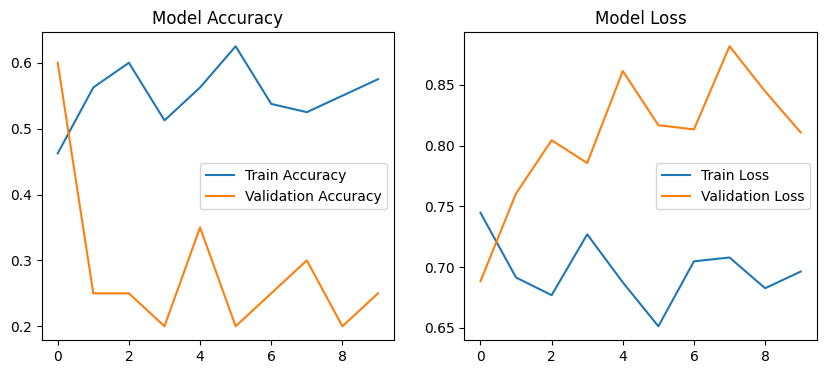

In [11]:
# ===============================
# Step 10: Plot Training History
# ===============================
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.legend()

plt.show()

In [12]:
# ===============================
# Step 11: Predict on New Sentences
# ===============================
def predict_sentiment(text):
    """
    Predict sentiment of a new sentence using Transformer-based model
    """
    # Clean text
    text = clean_text(text)
    # Convert to sequence
    seq = tokenizer.texts_to_sequences([text])
    # Pad sequence
    padded = pad_sequences(seq, maxlen=max_len, padding="post")
    # Predict
    prediction = model.predict(padded)
    return "Positive" if prediction[0][0] > 0.5 else "Negative"

# Test predictions
print(predict_sentiment("I really enjoyed this movie"))
print(predict_sentiment("This film was very boring"))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Positive
